In [1]:
!python -V

Python 3.10.13


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow

In [8]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("experiment_number_1")

<Experiment: artifact_location='/workspaces/ml-operational/experiments_tracking/mlruns/1', creation_time=1716427138970, experiment_id='1', last_update_time=1716427138970, lifecycle_stage='active', name='experiment_number_1', tags={}>

In [9]:
def load_and_preprocess(filename, categorical, target):
    """
    Read the filename and create a new column for the trip duration in mins,
    filtering of the data to 1 < min < 60 mins and converts the cat columns to strings
    """
    # Read the data
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    # df = pd.read_parquet(filename)
    
    # Create duration column in mins
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60
    
    # filter duration 
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # convert the cat into strings
    df[categorical] = df[categorical].astype(str)

    return df

Read the data:

In [12]:
train_path = 'taxi_data/yellow_tripdata_2023-01.parquet'
categorical = ['PULocationID', 'DOLocationID']
numerical_target = ['duration']

In [ ]:
df = load_and_preprocess(train_path, categorical, numerical_target)

Simple feature engineering: Use DictVectorizer to encode the categorical variables:

In [19]:
train_dicts = df[categorical].to_dict(orient='records')
train_dicts[:5]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'}]

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df[numerical_target].values

Train a new model:

In [22]:
with mlflow.start_run():
    mlflow.set_tag("ML engineer", "Javi Hdz")
    mlflow.log_param("train-data-path", train_path)

    #Hyperparameter:
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    
    rmse = root_mean_squared_error(y_train, y_pred)
    mlflow.log_metric("rmse", rmse)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Distributions of the predictions and target:

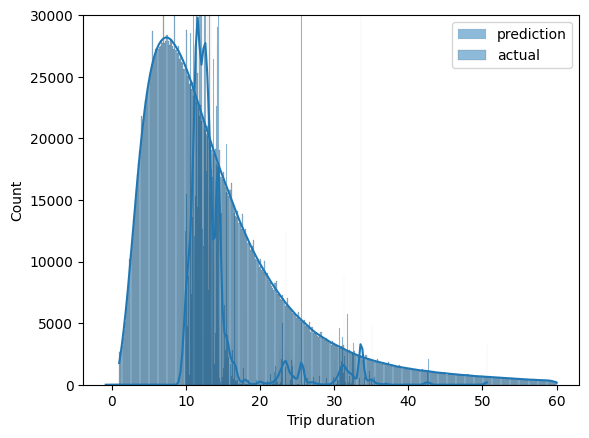

In [28]:
fig = sns.histplot(y_pred, label='prediction', kde=True, color='k')
plt.xlabel('Trip duration')
sns.histplot(y_train, label='actual', kde=True, color='r')
fig.set_ylim(0, 30000)
plt.legend()

### **Hyperparameter tunning:**

In [13]:
mlflow.set_experiment("HyperparametersTunning_1")

2024/05/24 00:13:32 INFO mlflow.tracking.fluent: Experiment with name 'HyperparametersTunning_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/ml-operational/experiments_tracking/mlruns/2', creation_time=1716509612366, experiment_id='2', last_update_time=1716509612366, lifecycle_stage='active', name='HyperparametersTunning_1', tags={}>

In [14]:
import xgboost as xgb

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train_path = 'taxi_data/yellow_tripdata_2023-01.parquet'
val_path = 'taxi_data/yellow_tripdata_2023-02.parquet'

In [18]:
df_train = load_and_preprocess(train_path, categorical, numerical_target)
df_val = load_and_preprocess(val_path, categorical, numerical_target)

print(f"train data size: {len(df_train)}, val data size: {len(df_val)}")

train data size: 3009173, val data size: 2855951


In [19]:
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [22]:
y_train = df_train[numerical_target].values
y_val = df_val[numerical_target].values

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 5)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    # 'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    # 'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)